### Introduction

My News Reader Project explores sentiment analysis using Reddit comments from the Politics subreddit to gauge public opinion. By training a machine learning model, the project aims to classify comments as positive, negative, or neutral, with a focus on the sentiments surrounding Donald Trump and Kamala Harris. Since the data is limited to a specific subreddit, this analysis is not a reliable reflection of overall public sentiment. However, it serves as a practical demonstration of how machine learning can be applied to achieve project objectives, such as text classification and sentiment analysis.

In [26]:
# import all the required libraries
import pandas as pd
import praw
import numpy as np

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

import string
import nltk
from nltk.corpus import stopwords

#### Data acquisition

For this project, I use the Reddit API to collect data from the Politics subreddit. I search for posts mentioning either 'Trump' or 'Harris' in the title and gather all associated comments. To facilitate data exploration, I first store the comments in separate lists and data frames, then merge them into a single dataset to train the machine learning model.

Since the data is initially unlabeled, I use VADER, a pre-trained sentiment analysis tool, to automatically label the comments, as manual labeling is not feasible for now. This labeling is essential for applying a supervised machine learning model, which requires labeled data for training.

Additionally, I have made the dataframes of titles, which I won't use.

In [2]:

# Initialize Reddit API connection
reddit = praw.Reddit(
    client_id='tZwMe0a2cneHp6qZz_x09w',
    client_secret='Hp-RZTXgWHFSayjB5177ZyKRPfVpQw',
    user_agent='Mean_Stuff7937'
)

# Lists to store the titles and comments
politics_titles_trump = []
politics_titles_harris = []

# List contains comments about posts related to Trump
comments_trump = []

# List contains comments about posts related to Harris
comments_harris = []

# Access the 'politics' subreddit
subreddit = reddit.subreddit('politics')

# Function to safely handle comments for a given post
def handle_comments(post, title_list, comment_list):
    title_list.append(post.title)
    post.comments.replace_more(limit=0)  # Collapse "load more comments"
    for comment in post.comments.list():
        comment_list.append(comment.body)

# Limit to a certain number of posts to avoid overwhelming the API
for post in subreddit.hot(limit=None):  # Fetch top 100 posts
    try:
        title_lower = post.title.lower()  # Make title lowercase for case-insensitive match

        # Check if 'trump' is in the title
        if 'trump' in title_lower:
            handle_comments(post, politics_titles_trump, comments_trump)

        # Check if 'harris' is in the title
        elif 'harris' in title_lower:
            handle_comments(post, politics_titles_harris, comments_harris)

    except Exception as e:
        print(f"An error occurred with post: {post.title}, error: {e}")
        time.sleep(2)  # Delay to avoid rate-limiting issues

# Print the count of titles containing 'Trump' and 'Harris'
print(f"Titles containing Trump: {len(politics_titles_trump)}")
print(f"Titles containing Harris: {len(politics_titles_harris)}")
print(f"There are total {len(comments_trump)} comments for Trump")
print(f"There are total {len(comments_harris)} comments for Harris")


Titles containing Trump: 461
Titles containing Harris: 83
There are total 55361 comments for Trump
There are total 8633 comments for Harris


#### Creating data frame for titles for each, Trump and Harris

In [3]:
# convert the above lists into dataframes
df_politics_titles_trump = pd.DataFrame(politics_titles_trump, columns=['politics_titles_Trump'])

# save the dataframe into a csv file
df_politics_titles_trump.to_csv("df_politics_titles_trump.csv")

df_politics_titles_trump

,politics_titles_Trump
0,"If Trump Wins in November, Life on Earth Is Li..."
1,If you thought Harris/Trump was brutal wait fo...
2,Brutal Video Shows Pace of Trump’s Cognitive D...
3,Trump Blames Everybody but Himself
4,Harris widens her lead over Trump in new 2024 ...
...,...
456,Twenty educators at Barron Trump’s new school ...
457,Trump Spent the Debate Walking Into Traps Harr...
458,Trump insists Russia’s war should end. But he ...
459,What the Debate Made Clear About a Second Trum...


In [4]:
# convert it to a dataframe
df_politics_titles_harris = pd.DataFrame(politics_titles_harris, columns=['politics_titles_harris'])

# save it to a csv file
df_politics_titles_harris.to_csv("df_politics_titles_harris.csv", index=False)

df_politics_titles_harris

,politics_titles_harris
0,Caitlin Clark on ‘liking’ Taylor Swift’s Harri...
1,Romney: Harris’s debate performance shows she’...
2,Taylor Swift's endorsement of Harris sends mor...
3,Poll: 52% of registered voters support Harris ...
4,Kamala Harris Leads Fox News' 'Power Rankings'...
...,...
78,Taylor Swift Endorses Kamala Harris
79,"After Taylor Swift's mega endorsement, it took..."
80,Taylor Swift endorses Kamala Harris for presid...
81,Taylor Swift endorses Harris


#### Creating data frames of comments for each, Trump and Harris

In [5]:
# dataframe for comments
df_politics_comments_trump = pd.DataFrame(comments_trump, columns=["Comments_trump"])

# save the dataframe into a csv file
df_politics_comments_trump.to_csv("politics_comments_trump.csv", index=False)

df_politics_comments_trump

,Comments_trump
0,"\nAs a reminder, this subreddit [is for civil ..."
1,As someone who doesn’t live in America I’m sur...
2,The Americas still have not recovered from Ron...
3,It's not sensationalist to point out that Trum...
4,The world still feeling the consequences of th...
...,...
55356,"And a drag queen. Fun fact, he's the same sui..."
55357,[deleted]
55358,I saw a Harvard economics professor on the new...
55359,"The sales tax one, at least, was a very poor r..."


In [6]:
# create a data frame for the comments
df_politics_comments_harris = pd.DataFrame(comments_harris, columns=['Comments_harris'])

# save it to a csv file
df_politics_comments_harris.to_csv("politics_comments_harris.csv")

df_politics_comments_harris

,Comments_harris
0,"\nAs a reminder, this subreddit [is for civil ..."
1,"Ah i see the ""freedom of speech is essential"" ..."
2,"I admire Swift (and Clark) saying basically ""d..."
3,And a lot of conservative RW’ers heads explode...
4,[deleted]
...,...
8628,Someone has to. It won’t come from the Republi...
8629,Sounds a bit cultish
8630,"Nah, she's a resident of Tennessee, so her vot..."
8631,"I agree, but I don't care."


### Using VADER to label the data

I use VADER here to label the datasets, as labelling them manually is not feasible at the moment.
VADER, a rule-based sentiment analysis tool for social media text (Hutto & Gilbert, 2014), to analyze the polarity of comments in Reddit.

In [7]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment label using VADER
def get_sentiment_label(comment):
    sentiment_dict = analyzer.polarity_scores(comment)
    compound_score = sentiment_dict['compound']
    
    # Assign sentiment label based on compound score
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Create the data frame for comments and sentiments
df_sentiments_trump = pd.DataFrame({
    'Comment': df_politics_comments_trump['Comments_trump']
})

# Apply VADER to auto-label comments
df_sentiments_trump['Sentiment'] = df_sentiments_trump['Comment'].apply(get_sentiment_label)

In [8]:
print(df_sentiments_trump)

                                                 Comment Sentiment
0      \nAs a reminder, this subreddit [is for civil ...  negative
1      As someone who doesn’t live in America I’m sur...  positive
2      The Americas still have not recovered from Ron...   neutral
3      It's not sensationalist to point out that Trum...  negative
4      The world still feeling the consequences of th...  negative
...                                                  ...       ...
55356  And a drag queen.  Fun fact, he's the same sui...  positive
55357                                          [deleted]   neutral
55358  I saw a Harvard economics professor on the new...  positive
55359  The sales tax one, at least, was a very poor r...  negative
55360  Not a lie at all.  She explained it clearly at...  positive

[55361 rows x 2 columns]


In [9]:
# Create the data frame for comments and sentiments
df_sentiments_harris = pd.DataFrame({
    'Comment': df_politics_comments_harris['Comments_harris']
})

# Apply VADER to auto-label comments
df_sentiments_harris['Sentiment'] = df_sentiments_harris['Comment'].apply(get_sentiment_label)

In [20]:
df_sentiments_harris

,Comment,Sentiment
0,"\nAs a reminder, this subreddit [is for civil ...",negative
1,Biden made a great decision,positive
2,"Here's a preview of the story: \n\nTim Ryan, t...",positive
3,“Trump insists he won debate in Truth Social r...,positive
4,It’s almost like there was divine intervention...,positive
...,...,...
7483,"In today's politics, everything is narrative b...",positive
7484,"Great, how much federal land in Pennsylvania i...",positive
7485,Failing production under Trump.,negative
7486,Here’s the thing she said her values didn’t ch...,positive


### Data Exploration

We look at both of the dataframe separately and see how the different sentiments are distributed for Harris and Trump.

According to the labels assigned to each comment in the dataset, we check the proportion of each class of sentiment (i.e positive, negative and neutral).

The overall count of comments for Trump is much higher than Harris and as it can be seen below, from the comments collected, there are almost equal proportion of negative and positive sentiment for Trump while the proportion of negative sentiments for Harris is lower.

In [21]:
# Count of sentiments in the dataset for Harris
sentiment_counts_harris = df_sentiments_harris['Sentiment'].value_counts()
print(sentiment_counts_harris)

Sentiment
positive    3498
negative    2263
neutral     1727
Name: count, dtype: int64


In [25]:
# count of sentiments in the dataset for Trump
sentiment_counts_trump = df_sentiments_trump['Sentiment'].value_counts()
print(sentiment_counts_trump)

Sentiment
positive    21091
negative    20128
neutral     12534
Name: count, dtype: int64


In [26]:
# compare the total counts of comments for Harris vs Trump 
trump_comments_count = len(df_politics_comments_trump)

harris_comments_count = len(df_politics_comments_harris)

print(f"No of comments related to Trump: {trump_comments_count}")
print(f"No of comments related to Harris: {harris_comments_count}")

No of comments related to Trump: 53753
No of comments related to Harris: 7488


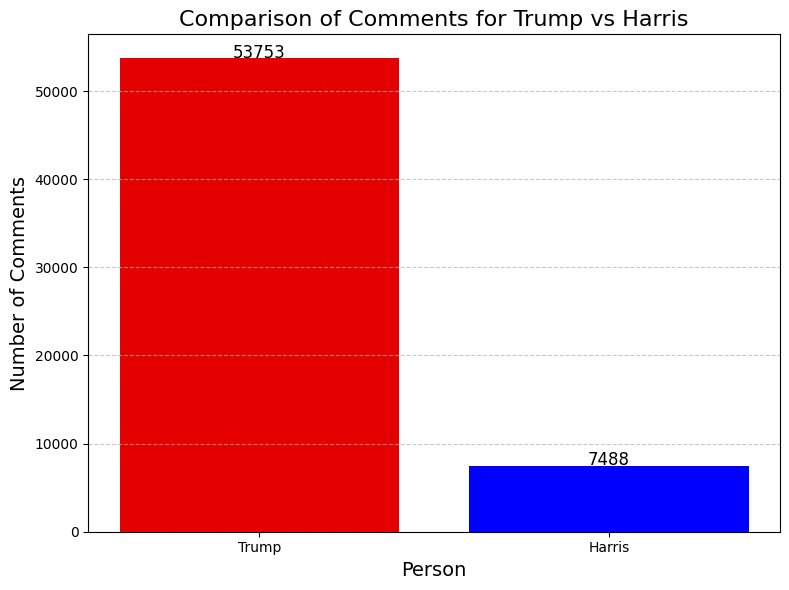

In [32]:
# Data for plotting
labels = ['Trump', 'Harris']
comment_counts = [trump_comments_count, harris_comments_count]

# Create a bar chart
plt.figure(figsize=(8, 6))  # Adjusts the size of the plot
bars = plt.bar(labels, comment_counts, color=['#E50000', 'blue'])

# Add labels, title, and grid
plt.title('Comparison of Comments for Trump vs Harris', fontsize=16)
plt.xlabel('Person', fontsize=14)
plt.ylabel('Number of Comments', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

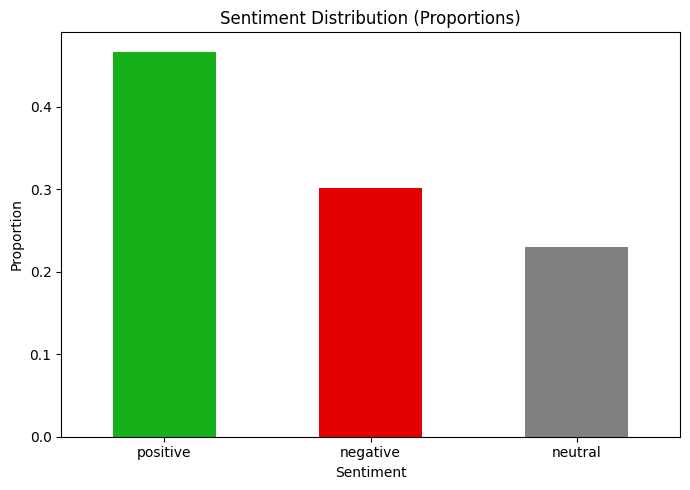

Sentiment
positive    0.467147
negative    0.302217
neutral     0.230636
Name: count, dtype: float64


In [33]:
total_counts_harris = sentiment_counts_harris.sum()

# Calculate proportions for each sentiment
sentiment_proportions_harris = sentiment_counts_harris / total_counts_harris

# Create a bar plot for proportions
plt.figure(figsize=(7,5))
sentiment_proportions_harris.plot(kind='bar', color=['#15B01A', '#E50000', 'gray'])

# Add labels and title
plt.title('Sentiment Distribution (Proportions)')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')

# Set x-axis ticks 
plt.xticks(rotation=0)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

print(sentiment_proportions_harris)

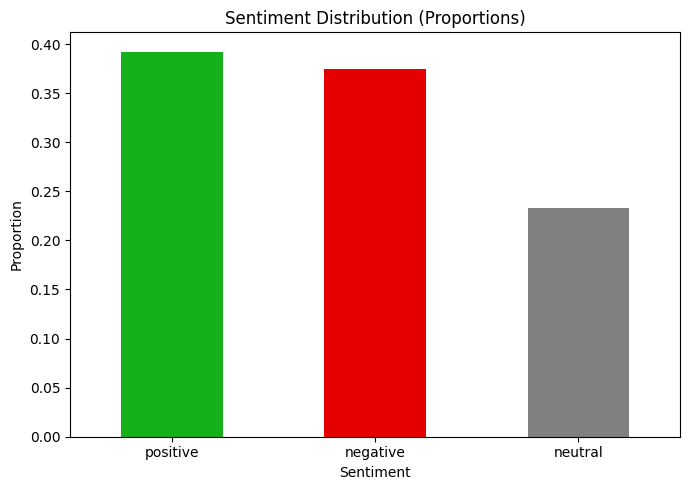

Sentiment
positive    0.392369
negative    0.374454
neutral     0.233178
Name: count, dtype: float64


In [34]:
total_counts_trump = sentiment_counts_trump.sum()

# Calculate proportions for each sentiment
sentiment_proportions_trump = sentiment_counts_trump / total_counts_trump


# Create a bar plot
plt.figure(figsize=(7, 5))
sentiment_proportions_trump.plot(kind='bar', color=['#15B01A', '#E50000', 'gray'])

# Add labels and title
plt.title('Sentiment Distribution (Proportions)')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')

# Set x-axis ticks for better readability
plt.xticks(rotation=0)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

print(sentiment_proportions_trump)

### Data Preparation

I want to merge both the comments datasets with their corresponding sentiments as labels.
I am preparing this merged dataset for sentiment classification task.

In the cell following to that I will apply some basic data cleaning which includes:
- In this process I will remove the the leading and trailing whitespaces. 
- Removing the comments where it is empty or too short. 
- Drop the missing values. 
- Reset index after cleaning.
- Changing the Sentiment column to be lowercase.


The sentiment labels are converted into numeric values ('positive' = 1, 'negative' = 0, 'neutral' = 2), and the data is split into training and testing sets. Using TF-IDF, the text comments are transformed into numerical features.

In [11]:
# Append df_sentiments_trump to df_sentiments_harris
df_merged = pd.concat([df_sentiments_harris, df_sentiments_trump], ignore_index=True)

# Display the shape of the merged dataframe
print(df_merged.shape)

# Display the first few rows of the merged dataframe to verify
print(df_merged.head())


(63994, 2)
                                             Comment Sentiment
0  \nAs a reminder, this subreddit [is for civil ...  negative
1  Ah i see the "freedom of speech is essential" ...  positive
2  I admire Swift (and Clark) saying basically "d...  positive
3  And a lot of conservative RW’ers heads explode...  positive
4                                          [deleted]   neutral


In [12]:
# Strip leading and trailing whitespaces from the 'Comment' column
df_merged['Comment'] = df_merged['Comment'].str.strip()

# Remove rows where 'Comment' is empty or too short (e.g., less than 5 characters)
df_merged = df_merged[df_merged['Comment'].str.len() > 5]

# Drop duplicate rows if any exist
df_merged = df_merged.drop_duplicates()

# Change the 'Sentiment' column to be lowercase
df_merged['Sentiment'] = df_merged['Sentiment'].str.lower()

# Check and drop any rows with missing values
df_merged = df_merged.dropna()

# Reset index after cleaning
df_merged = df_merged.reset_index(drop=True)

# Display the cleaned DataFrame shape and first few rows
print(df_merged.shape)
print(df_merged.head())

(62111, 2)
                                             Comment Sentiment
0  As a reminder, this subreddit [is for civil di...  negative
1  Ah i see the "freedom of speech is essential" ...  positive
2  I admire Swift (and Clark) saying basically "d...  positive
3  And a lot of conservative RW’ers heads explode...  positive
4                                          [deleted]   neutral


#### 

#### Removal of stop words from the comments

In [29]:
# Creating a copy of df_merged data frame
df_merged_clean = df_merged.copy()

In [22]:
# download nltk stopwords
nltk.download('stopwords')

# define stop words
stop_words = set(stopwords.words('english'))

# Function to clean the text
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

# Apply the clean_text function to the 'Comment' column
df_merged_clean['Comment'] = df_merged_clean['Comment'].apply(clean_text)

# Display the cleaned data
df_merged_clean['Comment'][112]

[nltk_data] Downloading package stopwords to /home/zabi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'find funny educate isnt really far research empty platitude doesnt actually say anything cant imagine upsets much ive done research catchphrase decade'

### Model Training and Evaluation


I then train a Logistic Regression model on the training data and evaluate its performance on the test set using accuracy and a classification report to assess precision, recall, and F1-score.

The model achieved an accuracy of approximately 81%, indicating that it correctly predicted the sentiment in 81% of the cases.

For negative (0) comments, the model has a precision of 0.82, recall of 0.76, and an F1-score of 0.79, showing it correctly identifies most negative comments but occasionally misses some.

For positive (1) comments, the precision is 0.83, recall is 0.83, and F1-score is 0.83, indicating balanced performance.

For neutral (2) comments, the model's precision is 0.77 and recall is 0.85, meaning it identifies neutral comments well but occasionally misclassifies others as neutral.

Overall, the model demonstrates balanced performance across all classes.

In [24]:
# Preprocess the data
# Convert 'Sentiment' to numeric form (e.g., 'positive' = 1, 'negative' = 0, 'neutral' = 2)
df_merged_clean['Sentiment'] = df_merged_clean['Sentiment'].map({'positive': 1, 'negative': 0, 'neutral': 2})


# Split the data into training and testing sets
X = df_merged_clean['Comment']  # Feature: the text comments
y = df_merged_clean['Sentiment']  # Target: sentiment labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data into numerical form using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test_tfidf)

# Evaluate the performance of the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.80930532077598

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79      4441
           1       0.83      0.83      0.83      5073
           2       0.77      0.85      0.81      2909

    accuracy                           0.81     12423
   macro avg       0.81      0.81      0.81     12423
weighted avg       0.81      0.81      0.81     12423



### Evaluation plots

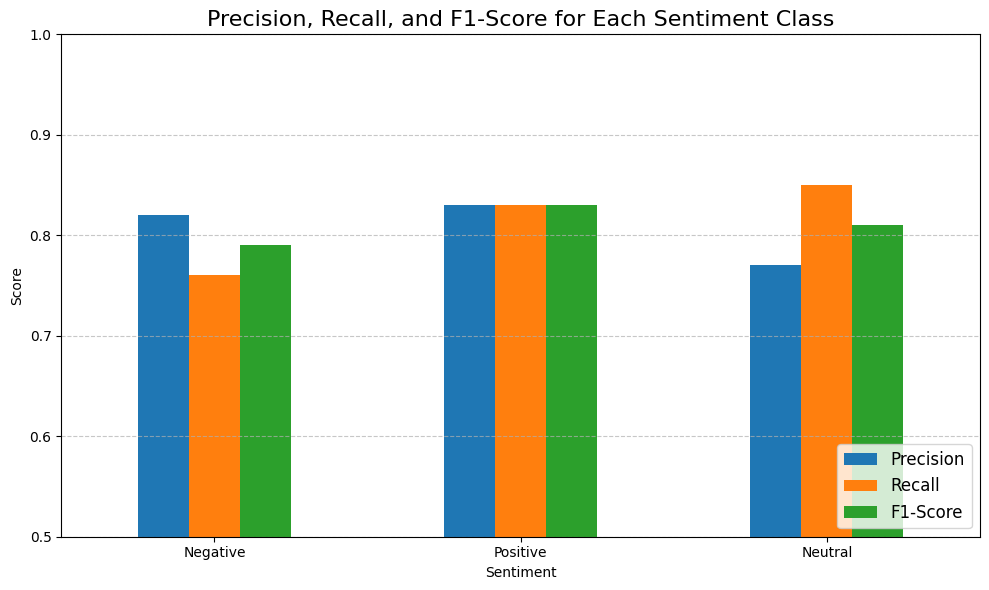

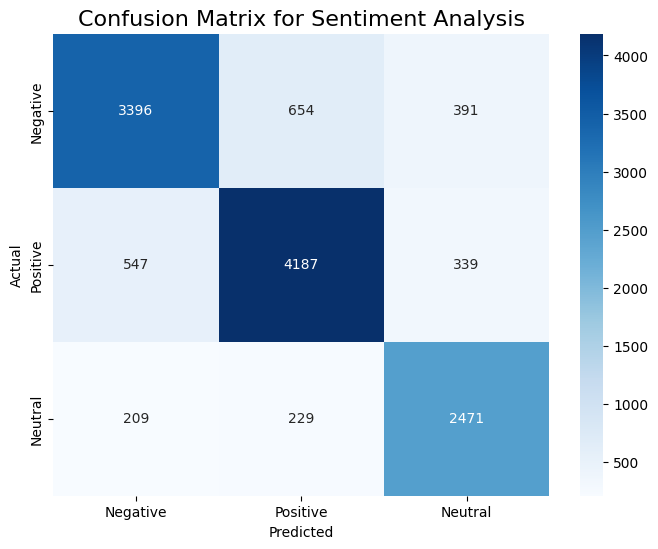

In [28]:
# Classification report dictionary for precision, recall, and f1-score
report = {
    'Sentiment': ['Negative', 'Positive', 'Neutral'],
    'Precision': [0.82, 0.83, 0.77],
    'Recall': [0.76, 0.83, 0.85],
    'F1-Score': [0.79, 0.83, 0.81]
}

# Create a DataFrame for easy plotting
df_report = pd.DataFrame(report)

# Plot precision, recall, and f1-score
fig, ax = plt.subplots(figsize=(10, 6))
df_report.set_index('Sentiment').plot(kind='bar', ax=ax)

plt.title('Precision, Recall, and F1-Score for Each Sentiment Class', fontsize=16)
plt.ylabel('Score')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=0)
plt.legend(loc='lower right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

# Confusion Matrix Visualization
y_pred = model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred)

# Labels for the confusion matrix
labels = ['Negative', 'Positive', 'Neutral']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix for Sentiment Analysis', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()